In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from ipykernel import kernelapp as app
import os
from keras.models import Sequential, Model 

from math import *
import random

from keras import backend as K

# model layers helpers
from keras.layers import Activation, Dropout, Flatten, Dense, ZeroPadding2D, Conv2D, Input, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras import regularizers
from keras.regularizers import l2
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping

# pre trained models
from keras.applications.vgg19 import VGG19

# image processing
from keras.preprocessing.image import img_to_array, ImageDataGenerator, load_img

from sklearn import model_selection

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Deep Learning libraries 
import tensorflow as tf

import scipy.io as cio

import random
import sys

# print(os.listdir("../input"))
print(os.listdir("~/.kaggle/input/compcar-misc"))

comp_car_root = "~/.kaggle/input/compcar-data"
misc_path = "~/.kaggle/input/compcar-misc"

# path for Model result (model creation JSON and Weights)
results_dir = "~/.kaggle/input/results"


Using TensorFlow backend.


FileNotFoundError: [Errno 2] No such file or directory: '~/.kaggle/input/compcar-misc'

In [ ]:
def if_ds_folder(folder_name):
    if folder_name == ".DS_Store":
        return True
    return False

def get_car_make_names():
    make_names = cio.loadmat(misc_path + '/make_model_name.mat')

    car_make_list = list(["NONE"])
    for i, car_make_name in enumerate(make_names["make_names"]):
        car_make_name = car_make_name[0][0]
        car_make_list.append(car_make_name)
        #print("Car Model: {}, folder: {}".format(car_make_name, i+1))
        
    print("Final car makes (includes None at index 0): " + str(len(car_make_list)))

    return car_make_list

def get_car_model_names():
    model_names = cio.loadmat(misc_path + '/make_model_name.mat')

    print("Initial car models: " + str(len(model_names["model_names"])))

    car_model_list = list(["NONE"])
    for i, car_model in enumerate(model_names["model_names"]):

        car_model = car_model[0][0] if len(car_model[0]) else "N/A"
        car_model_list.append(car_model)

    print("Final car models (includes None at index 0): " + str(len(car_model_list)))
    return car_model_list        

def get_actual_name(name_arr, index):
    return name_arr[int(index)] + "_" + index

In [ ]:
# Folder containing all the images.
car_make_path = comp_car_root + "/image/"
print('There are', len(os.listdir(car_make_path)),'folders in the training dataset')
#print(os.listdir(car_make_path))
        
car_make_names = get_car_make_names()
car_model_names = get_car_model_names()
    
compcar_data = list()
for car_make in os.listdir(car_make_path):
    if if_ds_folder(car_make): continue #ignore .DS_Store folder
    for car_model in os.listdir(car_make_path+car_make):
        if if_ds_folder(car_model): continue #ignore .DS_Store folder
        for car_year in os.listdir(car_make_path+car_make+'/'+car_model):
            if if_ds_folder(car_year): continue #ignore .DS_Store folder
            for img_name in os.listdir(car_make_path+car_make+'/'+car_model+'/'+car_year):
                if if_ds_folder(img_name): continue #ignore .DS_Store folder
                img_path = car_make_path+car_make+'/'+car_model+'/'+car_year+'/'+img_name
                
                # creating tuple
                data_tuple = (get_actual_name(car_make_names, car_make), 
                              get_actual_name(car_model_names, car_model), 
                              car_year, img_path)
                
                compcar_data.append(data_tuple)

compcar_df = pd.DataFrame(np.array(compcar_data).reshape(len(compcar_data),4), 
                          columns= ["car_make", "car_model", "car_year", "img_path"])
        


In [ ]:
car_makes_img_count = compcar_df['car_make'].value_counts().sort_values(ascending=False)
car_models_img_count = compcar_df['car_model'].value_counts().sort_values(ascending=False)

if(True):
    print("#######################")
    print("Number of cars per make")
    print("#######################\n")
    print(car_makes_img_count.head(5))

    print("\n\n#########################")
    print("Number of cars per model:")
    print("#########################\n")
    print(car_models_img_count.head(5))

In [2]:
CAR_MODELS = list(car_models_img_count.head(sys.argv[0]).keys()) # top N models

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNEL = 3
BATCH_SIZE = 64
NUM_CLASSES = len(CAR_MODELS)

# its a dictionary that needs to be set once data is filtered
LABELS = None 

print("Total number of classes to feed the model: " + str(NUM_CLASSES))

NameError: name 'car_models_img_count' is not defined

In [15]:
# filter_cars returns pandas objects having information as follows-
#           path                                     | class | label
#------------------------------------------------------------------------------------------------
# kaggle/input/stanford-car-dataset-by-c../img1.jpg  |  0   | Chrysler 300 SRT-8 2010
# kaggle/input/stanford-car-dataset-by-c../img2.jpg  |  1   | GMC Savana Van 2012
# kaggle/input/stanford-car-dataset-by-c../img3.jpg  |  2   | Mercedes-Benz 300-Class Convertible 1993
def filter_cars(df, filter_by_col='car_model', data_to_filter=CAR_MODELS):
    
    #copying only selected columns
    df = df[[filter_by_col, 'img_path']].copy()
    
    df = df[df[filter_by_col].isin(data_to_filter)] # filtering data
    df = df[df[filter_by_col].notnull()].copy() # removing null data if exists
    
    print("Consolidated total number of cars found: " + str(len(df))) 
    
    # adding new columns and mapping text labels to numeric data
    df['class'] = df[filter_by_col].astype("category").cat.codes 
    
    
    df = df.rename(columns = {
        filter_by_col:'label',
        'img_path':'path'
    })

    return df

In [16]:
filtered_dataset = filter_cars(compcar_df)
filtered_dataset = filtered_dataset.sample(frac=1).reset_index(drop=True)

print("filtered_dataset generated classes: " + str(sorted(filtered_dataset['class'].unique())))

c = filtered_dataset.label.astype('category')
LABELS = dict(enumerate(c.cat.categories))
print("LABELS: " + str(LABELS))
print('\n')

print('################################################')
print('SPLITTING DATA INTO TRAIN, VALIDATION AND TEST')
print('################################################\n')

training_split, test_split = model_selection.train_test_split(filtered_dataset, test_size=.2, random_state=1)
training_split, validation_split = model_selection.train_test_split(training_split, test_size=.2, random_state=1)

# resetting indices
training_split = training_split.reset_index(drop=True)
test_split = test_split.reset_index(drop=True)
validation_split = validation_split.reset_index(drop=True)


if(True):
    print("training_split.shape: {}, Post split classes # {}"
          .format(str(training_split.shape), len(sorted(training_split['class'].unique()))))
    print("validation_split.shape: {}, Post split classes # {}"
          .format(str(validation_split.shape), len(sorted(validation_split['class'].unique()))))
    print("test_split.shape: {}, Post split classes # {}"
          .format(str(test_split.shape), len(sorted(test_split['class'].unique()))))
    print('\n')

    print("################################")
    print("Number of cars in training_split")
    print("################################\n")
    print(training_split['label'].value_counts().sort_values(ascending=False))

    print("\n\n###################################")
    print("Number of cars in validation_split:")
    print("###################################\n")
    print(validation_split['label'].value_counts().sort_values(ascending=False))

    print("\n\n#############################")
    print("Number of cars in test_split:")
    print("#############################\n")
    print(test_split['label'].value_counts().sort_values(ascending=False))


Consolidated total number of cars found: 9039
filtered_dataset generated classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
LABELS: {0: 'Accord_213', 1: 'Audi A4L_2', 2: 'Audi A5 convertible_22', 3: 'Audi A5 coupe_23', 4: 'Audi A5 hatchback_24', 5: 'Audi A8L_27', 6: 'Audi Q5_5', 7: 'Aveo sedan_1917', 8: 'BAW E Series hatchback_342', 9: 'BWM 3 Series_68', 10: 'BWM 5 Series_70', 11: 'BWM X1_69', 12: 'BWM X5_105', 13: 'Benz E Class couple_154', 14: 'Benz E Class_127', 15: 'Benz GLA Class_175', 16: 'Benz GLK Class_126', 17: 'Besturn B70_367', 18: 'Bora_500', 19: 'Camry_1386', 20: 'Citroen C5_1259', 21: 'Civic_251', 22: 'Corolla_1323', 23: 'Cruze sedan_1908', 24: 'EXCELLE  GT_196', 25: 'Fiesta sedan_586', 26: 'Fit_215', 27: 'Golf_501', 28: 'KIA K2 sedan_1181', 29: 'Lacrosse_192', 30: 'New Focus hatchback_590', 31: 'New Focus sedan_591', 32: 'Oc

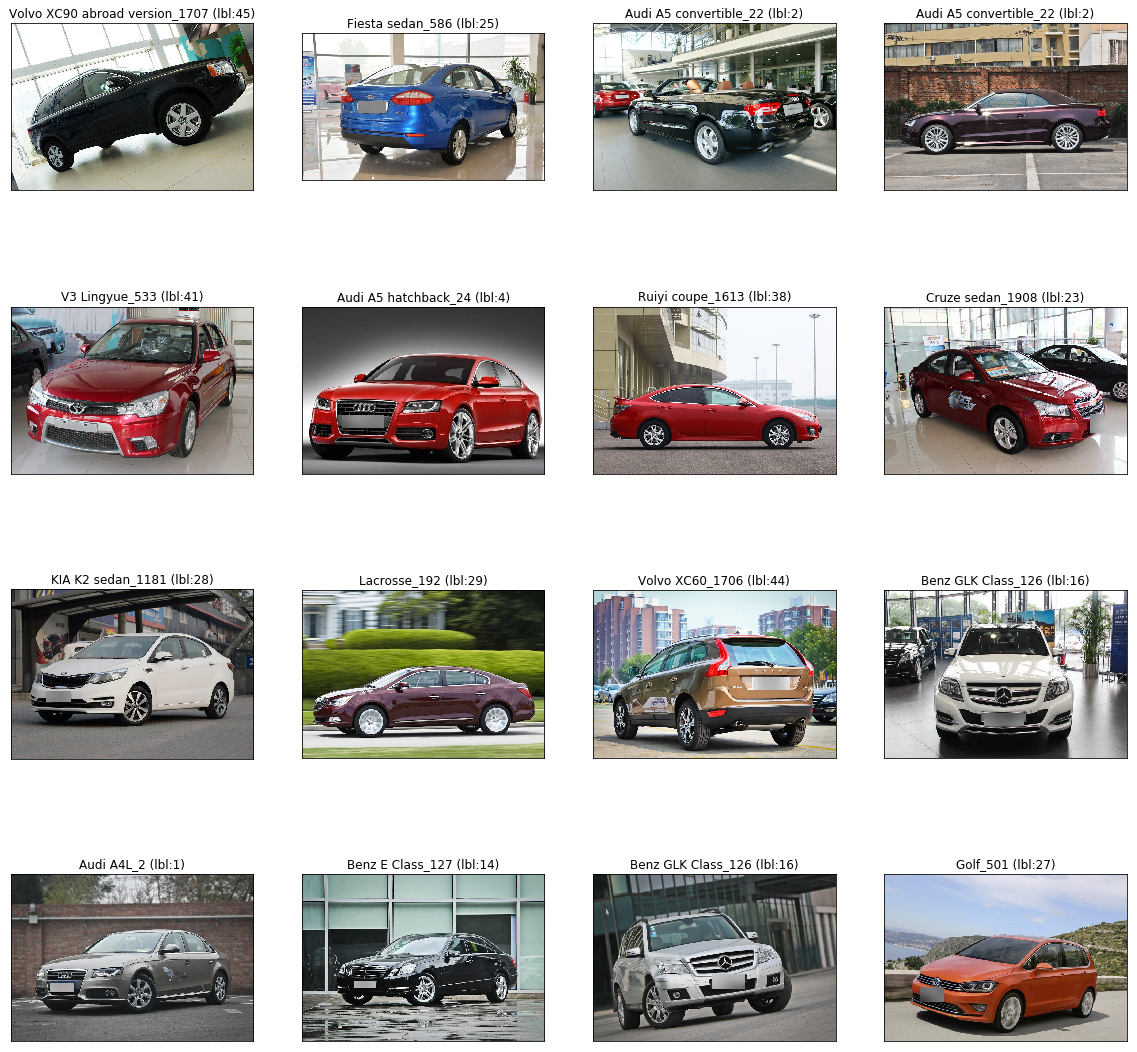

In [17]:
# PLOTTING IMAGES TO SEE
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
for i, axi in enumerate(ax.flat):
    #i = random.randint(0,len(train_img)-1)
    image = plt.imread(training_split.loc[i]['path'])
    axi.set_title("{0} (lbl:{1})".format(training_split.loc[i]['label'], str(training_split.loc[i]['class'])))
    axi.imshow(image)
    axi.set(xticks=[], yticks=[])

In [18]:
def save_model(model, training_history=None):
    # serialize model to JSON
    model_json = model.to_json()
    with open(results_dir + "/model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(results_dir + "/model.h5")
    
    #save model training history
    if(model_history is not None):
        np.save(open(results_dir + '/training_history.npy', 'wb'), training_history)

    print("Saved model, weights and training history to disk.")
    
    
def load_model(compile_model=False):
    from keras.models import model_from_json
    # load json and create model
    json_file = open(results_dir + '/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(results_dir + "/model.h5")
    print("Loaded model and weights from disk")
    
    if(compile_model):
        # compile the model 
        loaded_model.compile(loss = "categorical_crossentropy", optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
        print("\nModel compiling done..")
    
    return loaded_model

def build_vgg(load_weights=False):
    model = VGG19(weights = "imagenet", include_top=False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL))

        # Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
    for layer in model.layers[:5]:
        layer.trainable = False

    #Adding custom Layers 
    x = model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(NUM_CLASSES, activation="softmax")(x)

    # creating the final model 
    model_final = Model(inputs=model.input, outputs=predictions)
    
    # loading weights if True
    if load_weights == True:
        model_final.load_weights(results_dir + "/model.h5")
        print("Loaded model and weights from disk")
    

    # compile the model 
    model_final.compile(loss = "categorical_crossentropy", optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

    
    return model_final

In [19]:
# re-sizing images
def resize_image(img_path):
    # load an image from file
    img = Image.open(img_path)
    #img = img.convert('RGB')
    img = img.resize((IMAGE_HEIGHT,IMAGE_WIDTH), Image.ANTIALIAS)
    img = np.array(img)

    return img

# fuction only to read image from file
def get_image(index, data):
    # Read image and appropiate traffic light color
    image = resize_image(data['path'].values[index].strip())
    img_class = data['class'].values[index]
    
    return [image, img_class]

# generator function to return images batchwise
def generator(data, batches=None):
    data_batches = None
    
    print("custom batch size: " + str(batches))
    if(batches is not None): # custom batch size
        data_batches = batches
    else: # default batch size
        data_batches = BATCH_SIZE
        
    print("default batch size: " + str(data_batches))
    
    while True:        
        # Randomize the indices to make an array
        indices_arr = np.random.permutation(data.count()[0])
        for batch in range(0, len(indices_arr), data_batches):
            # print("batch: " + str(batch))
            # slice out the current batch according to batch-size
            current_batch = indices_arr[batch:(batch + data_batches)]

            # initializing the arrays, x_train and y_train
            x_train = np.empty([0, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL], dtype=np.float32)
            y_train = np.empty([0], dtype=np.int32)

            for i in current_batch:
                [image, img_class] = get_image(i, data)

                # Appending them to existing batch
                x_train = np.append(x_train, [image], axis=0)
                y_train = np.append(y_train, [img_class])

                # plt.title(img_class)
                # plt.imshow(x_train[0])

            y_train = to_categorical(y_train, num_classes=NUM_CLASSES)

            yield (x_train, y_train)
    
# generator for training and validation purpose
train_img_data_gen = ImageDataGenerator(rescale=1. / 255)

# generator for testing model results purpose
test_img_data_gen = ImageDataGenerator(rescale=1. / 255)
        
def create_aug_gen(in_gen, passingTestData=False, verbose=False):
    
    gen = test_img_data_gen if passingTestData else train_img_data_gen
    
    for in_x, in_y in in_gen:
        g_x = gen.flow(in_x, in_y, batch_size=in_x.shape[0])
        x, y = next(g_x)
        yield x, y  
        
        if(verbose):
            print("g_x.n: " + str(g_x.n))
            print('x', x.shape, x.dtype, x.min(), in_x.max())
            print('y', y.shape, y.dtype, y.min(), in_y.max())
        
def graph(t_x, t_y, rows=4, columns=4, figsize=(20, 20), predicted=None):
    # PLOTTING IMAGES TO SEE
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    for i, axi in enumerate(ax.flat):
        #i = random.randint(0,len(t_x)-1)
        title = ""
        title_color = 'black'
            
        actual_img_class = np.argmax(t_y[i])
        actual_img_label = LABELS.get(actual_img_class)
        title += actual_img_label
        
        if(predicted is not None):
            predicted_img_class = predicted[i]
            predicted_img_label = LABELS.get(predicted_img_class)
            title += "\n"
            title += "prediction: \n" + predicted_img_label
            
            if(predicted_img_class != actual_img_class):
                title_color = 'red'
            else:
                title_color = 'green'
        
        axi.set_title(title, color=title_color)
        axi.imshow(t_x[i])
        axi.set(xticks=[], yticks=[])

In [20]:
training_gen = create_aug_gen(generator(training_split))
validation_gen = create_aug_gen(generator(validation_split))

In [ ]:
#####################
# TESTING GENERATORS
####################

t_x, t_y = next(training_gen)
graph(t_x, t_y)

In [ ]:
model = build_vgg()
#model.summary()

print('Training started....')
NUM_EPOCH = 500

# early stop callback, given a bit more leeway
e_stop = EarlyStopping(monitor='val_acc', min_delta=0.0001,
                              patience=5,
                              verbose=1, mode='auto')

model_history = model.fit_generator(
    training_gen,
    steps_per_epoch=len(training_split)//BATCH_SIZE,
    epochs=NUM_EPOCH,
    validation_data=validation_gen,
    validation_steps=len(validation_split)//BATCH_SIZE,
    verbose=1,
    callbacks=[e_stop]
)

################
# LOADING MODEL
################
# model = load_model()
# model.compile(loss = "categorical_crossentropy", optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])


plt.figure(0)
plt.plot(model_history.history['acc'],'r')
plt.plot(model_history.history['val_acc'],'g')
plt.xticks(np.arange(0, e_stop.stopped_epoch, 5.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(model_history.history['loss'],'r')
plt.plot(model_history.history['val_loss'],'g')
plt.xticks(np.arange(0, e_stop.stopped_epoch, 5.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

save_model(model, model_history)

In [ ]:
#####################
# Evaluating accuracy
#####################
test_gen = create_aug_gen(generator(test_split), passingTestData=True)
accuracy = model.evaluate_generator(test_gen, steps=len(test_split)//BATCH_SIZE, max_queue_size=10, workers=1, use_multiprocessing=False, verbose = 1)
print('Test accuracy:', accuracy[1])

In [ ]:
# Predicton and Confusion Matrix

# https://cs.stackexchange.com/questions/70627/how-can-i-restructure-matrices-to-have-non-zero-elements-close-to-the-diagonal